In [ ]:
###########################################################################################################
############################################## UTA's OurCS ################################################
###########################################################################################################
############################ Tensorflow 2.0 / Neural Networks / CNN Workshop ##############################
###########################################################################################################
########################################## Gunshot Recognition  ###########################################
###########################################################################################################

In [19]:
# Cell 1: Libraries and dependency imports.

#Jupyter Notebook from iPython Module

# Module for memory usage monitoring
from memory_profiler import memory_usage  

# Module for OS functions use
import os
# Garbage collector for optimizing memory use
import gc
# Module for data analysis, file manipulation
import pandas as pd                       
# Module for file manipulation, pattern matching, similar to regex
from glob import glob                      
# Module for N-dimensional array object creation, file manipulation 
import numpy as np  
# Module for working with OS paths
from path import Path

# Module for model metrics
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import tensorflow as tf; print("Tensorflow", tf.__version__)

from tensorflow.keras.models import * #(Sequential, Model)
from tensorflow.keras.layers import * #(Input, Dense, Activation, LSTM, Lambda, Pooling, Flatten, Dropout,etc.)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import * #(Adam, RMSprop, SGD #stochaist gradient descent)
from tensorflow.keras.preprocessing.image import ImageDataGenerator #dynamic datasets and input generation

# Module for audio manipulation, spectrogram generation
import librosa
import librosa.display

# Module for chart plotting
import matplotlib.pyplot as plt
from matplotlib import figure
# iPython line function for plotting outputs directly into frontend (Jupyter Notebook) 
%matplotlib inline                                                                     

Tensorflow 2.0.0


In [20]:
# Cell 2: Determination of all local folders to be used.

MODELWEIGHTS_PATH = "modelWeights"
TRAIN_AUDIO_PATH = "train"
VALID_AUDIO_PATH = "valid"
TEST_AUDIO_PATH  = "test"
TRAIN_SPECT_PATH = "ktrain"
VALID_SPECT_PATH = "kvalid"
TEST_SPECT_PATH  = "ktest"

In [21]:
# Cell 3: Definition of class dictionary to be used for this task.

audiodata_classes = {0:0, 1:1} 
backwards_classes = {v: k for k, v in audiodata_classes.items()}
print(audiodata_classes)
print(backwards_classes)
class_labels = audiodata_classes.keys()
print(class_labels)

{0: 0, 1: 1}
{0: 0, 1: 1}
dict_keys([0, 1])


In [22]:
# Cell 4: Definition of function to retrieve (from local folders) audio files to be used.

def get_audio_files(audio_dir):
    audio_files = []
    for _, dirnames, files in os.walk(audio_dir):
        if dirnames == []:
            audio_files.extend(int(file[:-4]) for file in files)
    return audio_files

def get_audio_path(audio_dir, audio_id):
    return os.path.join(audio_dir, str(audio_id) + '.wav')   

In [23]:
# Cell #5: Definition of arrays containing the IDs of files found on local folders.

train_audio_files = get_audio_files(TRAIN_AUDIO_PATH)
valid_audio_files = get_audio_files(VALID_AUDIO_PATH)
test_audio_files = get_audio_files(TEST_AUDIO_PATH)
print(len(train_audio_files))
print(len(valid_audio_files))
print(len(test_audio_files))

500
0
400


In [24]:
# Cell 6: Confirm we can read from train CSV file.

trainaudiodata_samples = pd.read_csv(r'train.csv', index_col=0) #local file
trainaudiodata_columns = [('Class')]

traindataflow_full = trainaudiodata_samples[trainaudiodata_columns]

traindataflow_full['ID'] = traindataflow_full.index
traindataflow_full.head()

,Class,ID
ID,,
1100,1,1100
1101,1,1101
1102,1,1102
1103,1,1103
1104,1,1104


In [25]:
#Cell 7: Confirm train array shape (should be number of files by number of classes found on CSV)

traindataflow_full.shape  

(500, 2)

In [26]:
# Cell 8: Confirm classes present in train CSV
traindataflow_full[('Class')].unique() 

array([1, 0], dtype=int64)

In [27]:
# Cell 9: Confirm we can read from test CSV file.

testaudiodata_samples = pd.read_csv(r'test.csv', index_col=0)
testaudiodata_columns = [('Class')]

testdataflow_full = testaudiodata_samples[testaudiodata_columns]

testdataflow_full['ID'] = testdataflow_full.index
testdataflow_full.head()

,Class,ID
ID,,
4800,1,4800
4801,1,4801
4802,1,4802
4803,1,4803
4804,1,4804


In [28]:
#Cell 10: Confirm test array shape (should be number of files by number of classes found on CSV)

testdataflow_full.shape    

(400, 2)

In [29]:
# Cell 11: Confirm classes present in test CSV

testdataflow_full[('Class')].unique()   

array([1, 0], dtype=int64)

In [30]:
# Cell 12: Definition of function for individual training / testing spectrogram generation

def create_spectrogram(audio_id, setfolder):
    if setfolder == "train":
        filename = get_audio_path(TRAIN_AUDIO_PATH, audio_id)
        targetfolder = TRAIN_SPECT_PATH
    elif setfolder == "valid": 
        filename = get_audio_path(VALID_AUDIO_PATH, audio_id)
        targetfolder = VALID_SPECT_PATH
    else:
        filename = get_audio_path(TEST_AUDIO_PATH, audio_id)
        targetfolder = TEST_SPECT_PATH
        
    targetfilename  = targetfolder + "/" + str(audio_id) + '.jpg'       
        
    plt.interactive(False)
    sample, sample_rate = librosa.load(filename, sr=None)
    fig = plt.figure(figsize=[1,1])       #setting spectrogram size of 1 by 1 inch
    ax = fig.add_subplot(111)             #one single grid generated everytime the function is called 
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    
    #Sampling Rate = 44100Hz (above frequencies human hearing can hear), 
    #Window of time of each frame in each audio sample to perform FFT, 2048, which is equivalent to 10ms (minimum possible time length for human ear to distinguish a sound)
    #Hop = Number of samples between successive frames. 512 image samples skipped between FFTs
    #Number of mels = 128, meaning the the distance between the stacked frequencies 
    spectrogramImage = librosa.feature.melspectrogram(y=sample, sr=44100, n_fft=2048, hop_length=512, n_mels=128)
    librosa.display.specshow(librosa.power_to_db(spectrogramImage, ref=np.max))
    
    plt.savefig(targetfilename, dpi=400, bbox_inches='tight',pad_inches=0)
    plt.close()    
    fig.clf()
    plt.close(fig)
    plt.close('all')
    del filename,sample,sample_rate,fig,ax,spectrogramImage

In [31]:
# Cell 13: Definition of function for generation of spectrogram in batches 

def generate_datasets(setfolder):
    count = 0
    failcount = 0
    #Exception treatment
    
    if setfolder == "train":
        dataflow = traindataflow_full
    elif setfolder == "valid": 
        dataflow = validdataflow_full
    else:
        dataflow = testdataflow_full
        
    dataflow_dict = dataflow.to_dict()
    total_rows = len(dataflow_dict['ID'])
    
    for index, row in dataflow.iterrows():
        try:
            count += 1
            audio_id = int(row['ID'])
            spectrogram = create_spectrogram(audio_id, setfolder)

            if count % 5 == 0:
                accumcount = count - failcount
                print("Successfully processed 5 new samples - total spectrograms generated:", accumcount)
        except:
                failcount += 1
                print("FAILED - spectrogram generation failed for item:", count, "| file ID:", audio_id)
                continue

In [14]:
# Cell 14: Call for generating training spectrograms

generate_datasets("train")

Successfully processed 5 new samples - total spectrograms generated: 5
Successfully processed 5 new samples - total spectrograms generated: 10
Successfully processed 5 new samples - total spectrograms generated: 15
Successfully processed 5 new samples - total spectrograms generated: 20
Successfully processed 5 new samples - total spectrograms generated: 25
Successfully processed 5 new samples - total spectrograms generated: 30
Successfully processed 5 new samples - total spectrograms generated: 35
Successfully processed 5 new samples - total spectrograms generated: 40
Successfully processed 5 new samples - total spectrograms generated: 45
Successfully processed 5 new samples - total spectrograms generated: 50
Successfully processed 5 new samples - total spectrograms generated: 55
Successfully processed 5 new samples - total spectrograms generated: 60
Successfully processed 5 new samples - total spectrograms generated: 65
Successfully processed 5 new samples - total spectrograms generat

In [15]:
# Cell 15: Call for generating test spectrograms

generate_datasets("test")

Successfully processed 5 new samples - total spectrograms generated: 5
Successfully processed 5 new samples - total spectrograms generated: 10
Successfully processed 5 new samples - total spectrograms generated: 15
Successfully processed 5 new samples - total spectrograms generated: 20
Successfully processed 5 new samples - total spectrograms generated: 25
Successfully processed 5 new samples - total spectrograms generated: 30
Successfully processed 5 new samples - total spectrograms generated: 35
Successfully processed 5 new samples - total spectrograms generated: 40
Successfully processed 5 new samples - total spectrograms generated: 45
Successfully processed 5 new samples - total spectrograms generated: 50
Successfully processed 5 new samples - total spectrograms generated: 55
Successfully processed 5 new samples - total spectrograms generated: 60
Successfully processed 5 new samples - total spectrograms generated: 65
Successfully processed 5 new samples - total spectrograms generat

In [32]:
# Cell 16: Load dataframes (Training and Validation) with generated spectrograms
# Keras datagenerators are used. They will handle the loading and processing of images.
# Different data augmentation techniques are available.

def append_ext(fn):
    return fn+".jpg"

# repurposing the dataflows from object to string type
traindataflow_full = pd.read_csv(r'train.csv',dtype=str)
testdataflow_full = pd.read_csv(r'test.csv',dtype=str)

traindataflow_full["ID"]=traindataflow_full["ID"].apply(append_ext)
testdataflow_full["ID"]=testdataflow_full["ID"].apply(append_ext)

#Initializes an Data Augmenter as an ImageDataGenerator class object
datagen=ImageDataGenerator(rescale=1./255.,
                           validation_split=0.25) 

#Initializes an Data Augmenter as an ImageDataGenerator class object. Performs augmentation
#datagen=ImageDataGenerator(rescale=1./255., 
#                           validation_split=0.25,
#                           featurewise_center=False, 
#                           samplewise_center=False, 
#                           featurewise_std_normalization=False, 
#                           samplewise_std_normalization=False, 
#                           zca_whitening=False, 
#                           zca_epsilon=1e-06, 
#                           rotation_range=0, 
#                           width_shift_range=0.0, 
#                           height_shift_range=0.0, 
#                           brightness_range=None, 
#                           shear_range=0.0, 
#                           zoom_range=0.0, 
#                           channel_shift_range=0.0, 
#                           fill_mode='nearest', 
#                           cval=0.0, 
#                           horizontal_flip=False, 
#                           vertical_flip=False, 
#                           preprocessing_function=None, 
#                           data_format='channels_last',   
#                           interpolation_order=1, 
#                           dtype='float32')

#Key augumentations
#datagen=ImageDataGenerator(rescale=1./255.,
#                           validation_split=0.25,
#                           rotation_range=0.25,
#                           width_shift_range=0.1,
#                           height_shift_range=0.1,
#                           shear_range=0.2, 
#                           zoom_range=0.2, 
#                           brightness_range=[0.2,0.8]
#) 

#Flow from dataframe use because we use spreadsheets with information on classes.
train_generator=datagen.flow_from_dataframe(  
    dataframe=traindataflow_full,
    directory=TRAIN_SPECT_PATH,   
    x_col="ID",
    y_col="Class",
    subset="training",
    batch_size=50,
    shuffle=True,
    class_mode="categorical", #binary
    target_size=(64,64)) #transformed images from datagenerator will have 64 by 64 pixels

#check if this saving code works for saving augumented images
#train_generator = datagen.flow(img, save_to_dir='C:/ktrainaug/', save_format='jpeg', save_prefix='aug')

#In here, we split our training set into Training and Validation sets
#of the hyperparameters. This set does not influence the model performance directly.
valid_generator=datagen.flow_from_dataframe(
    dataframe=traindataflow_full,
    directory=TRAIN_SPECT_PATH,     
    x_col="ID",
    y_col="Class",
    subset="validation",
    batch_size=50,
    shuffle=True,
    class_mode="categorical", #binary
    target_size=(64,64)) #transformed images from datagenerator will have 64 by 64 pixels


Found 375 validated image filenames belonging to 2 classes.
Found 125 validated image filenames belonging to 2 classes.


In [152]:
# Cell 17: Definition of CNN Model hyperparameters

#choose here your batch size
BATCH_SIZE = 20 #YOUR BATCH SIZE

#choose here your number of classes
CLASSES_NUM = 2#YOUR CLASS NUMBER

#choose here the input shape for your model
INPUT_SHAPE = (64, 64, 3) #YOUR INPUT SHAPE

#choose here the number of filters. Tip: Different Conv layers may use different filter numbers.
FILTER2D_NUM1 = 64 #YOUR NUMBER OF FILTERS
FILTER2D_NUM2 = 128
FILTER2D_NUM3 = 256

#choose here your filter sizes. See above tip.
FILTER2D_SIZE1 = (3, 3) # YOUR FILTER SIZE
FILTER2D_SIZE2 = (3, 3)
FILTER2D_SIZE3 = (3, 3)

PADDING = "same"

#choose here your pooling size
POOL2D_SIZE   = (2, 2) #YOUR POOLING SIZE

#choose here the dropout rate
DROP_RATE_MIN = 0.1 #YOUR DROPOUT RATE
DROP_RATE_MAX = 0.2 #YOUR DROPOUT RATE

#choose your optimizer
OPTIMIZER   = tf.optimizers.Adam(lr=0.0005)  # YOUR OPTIMIZER

#choose your activations
INTERMEDIARY_ACTIVATION = 'relu' #YOUR ACTIVATION
DENSE_ACTIVATION = 'sigmoid'  #YOUR ACTIVATION

#choose here your number of hidden units
HIDDEN_UNITS = 512 #YOUR DENSE NEURONS

#choose your loss function
LOSS_FUNCTION = "binary_crossentropy"#YOUR LOSS FUNCTION

#choose the metrics you will use to tune your CNN
METRICS = ["accuracy"]#YOUR MAIN METRICS

#choose here the training iterations
EPOCH_COUNT = 50 #YOUR TRAINING ITERATIONS

In [153]:
# Cell 20: Definition of additional key parameters settings
MONITORED_METRICS= "val_accuracy"  #YOUR MAIN MONITORING METRICS
FACTOR           = 0.5   #LR will be reduced by this rate #YOUR LR REDUCING FACTOR
PATIENCE         = 10    #Iterations without improvement before triggering LR change #YOUR PATIENCE
DELTA            = 0.01  #Minimum improvement needed for considering upgrade  #YOUR IMPROVEMENT DELTA
WEIGHTSFILENAME  = "ourCS.h5" #YOUR WEIGHTS FILE NAME
NEWWEIGHTSPATH   = MODELWEIGHTS_PATH + "/" + WEIGHTSFILENAME

In [154]:
# Cell 21: Define model architecture, compile and summarize model.


model = tf.keras.Sequential([

#########YOUR LAYERS HERE
#########YOUR LAYERS HERE
#########YOUR LAYERS HERE
#########YOUR LAYERS HERE
    tf.keras.layers.Convolution2D(FILTER2D_NUM1, FILTER2D_SIZE1, padding="same", input_shape = (64,64,3)),
    tf.keras.layers.Activation(INTERMEDIARY_ACTIVATION),
    tf.keras.layers.MaxPooling2D(pool_size = POOL2D_SIZE),
    tf.keras.layers.Dropout(rate = DROP_RATE_MIN),
    
    tf.keras.layers.Convolution2D(FILTER2D_NUM2, FILTER2D_SIZE2, padding = "same"),
    tf.keras.layers.Activation(INTERMEDIARY_ACTIVATION),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(rate = DROP_RATE_MIN),
    
    tf.keras.layers.Convolution2D(FILTER2D_NUM3, FILTER2D_SIZE3, padding = "same"),
    tf.keras.layers.Activation(INTERMEDIARY_ACTIVATION),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(rate = DROP_RATE_MIN),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(HIDDEN_UNITS),
    tf.keras.layers.Activation(DENSE_ACTIVATION),
    tf.keras.layers.Dropout(rate = DROP_RATE_MAX),
    tf.keras.layers.Dense(CLASSES_NUM),
    tf.keras.layers.Activation('softmax'),
    
    
])

#Compilation of model. Two arguments are absolutely required, namely Optimizer and Loss Function definitions
model.compile(OPTIMIZER,loss=LOSS_FUNCTION,metrics=METRICS)
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
activation_64 (Activation)   (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_64 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
activation_65 (Activation)   (None, 32, 32, 128)       0         
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 16, 16, 128)     

In [155]:
# Cell 22: Definition of function for triggering the model training 
def NN_Model_Trainer(model):
    STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size #number of train samples by batch size
    STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size #number of validation samples by batch size

    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(NEWWEIGHTSPATH, 
                                                             monitor=MONITORED_METRICS, 
                                                             verbose=1,
                                                             save_best_only=True, 
                                                             include_optimizer=False,
                                                             mode='max')
    
    reducelr_callback = tf.keras.callbacks.ReduceLROnPlateau(
                monitor=MONITORED_METRICS, factor=FACTOR, patience=PATIENCE, min_delta=DELTA,
                verbose=1
        )

    callbacks_list = [checkpoint_callback, reducelr_callback]

    print('Neural Network Training Initiated....')
    history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=EPOCH_COUNT,
                    callbacks=callbacks_list)

    model.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_VALID)
    
    print('Neural Network Training Completed....')
    return model, history

In [156]:
# Cell 23: Definition of function for plotting key model statistics after training is complete.
def NN_Model_Summarizer(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['accuracy - train', 'accuracy - val'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['loss - train', 'loss - val'], loc='upper left')
    plt.show()

In [157]:
# Cell 24: CNN model resetter - Use only on the two situations below
###########################################################################################################
### RUN THIS CELL ONLY IF YOU WISH TO RESET THE GENERATORS, OTHERWISE THEY'LL KEEP RUNNING CUMULATIVELY ###
###########################################################################################################
###########################################################################################################
############################## RUN THIS CELL AFTER YOU CHANGE MODEL SETTINGS ##############################
###########################################################################################################
train_generator.reset()
valid_generator.reset()

In [158]:
# Cell 25: Run the model!
model, history = NN_Model_Trainer(model)

Neural Network Training Initiated....
Epoch 1/50
6/7 [========================>.....] - ETA: 1s - loss: 0.6128 - accuracy: 0.6945
Epoch 00001: val_accuracy improved from -inf to 0.58000, saving model to modelWeights/ourCS.h5
7/7 [==============================] - 14s 2s/step - loss: 0.5845 - accuracy: 0.7077 - val_loss: 0.7463 - val_accuracy: 0.5800
Epoch 2/50
6/7 [========================>.....] - ETA: 1s - loss: 0.3269 - accuracy: 0.8800
Epoch 00002: val_accuracy improved from 0.58000 to 0.91000, saving model to modelWeights/ourCS.h5
7/7 [==============================] - 15s 2s/step - loss: 0.3140 - accuracy: 0.8857 - val_loss: 0.2160 - val_accuracy: 0.9100
Epoch 3/50
6/7 [========================>.....] - ETA: 1s - loss: 0.2774 - accuracy: 0.8873
Epoch 00003: val_accuracy did not improve from 0.91000
7/7 [==============================] - 14s 2s/step - loss: 0.2585 - accuracy: 0.8985 - val_loss: 0.3495 - val_accuracy: 0.9100
Epoch 4/50
6/7 [========================>.....] - ETA: 1s

Epoch 30/50
6/7 [========================>.....] - ETA: 1s - loss: 0.0032 - accuracy: 1.0000
Epoch 00030: val_accuracy did not improve from 0.99000
7/7 [==============================] - 15s 2s/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0689 - val_accuracy: 0.9700
Epoch 31/50
6/7 [========================>.....] - ETA: 1s - loss: 0.0029 - accuracy: 1.0000
Epoch 00031: val_accuracy did not improve from 0.99000
7/7 [==============================] - 12s 2s/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.0633 - val_accuracy: 0.9800
Epoch 32/50
6/7 [========================>.....] - ETA: 1s - loss: 0.0016 - accuracy: 1.0000
Epoch 00032: val_accuracy did not improve from 0.99000
7/7 [==============================] - 13s 2s/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0620 - val_accuracy: 0.9800
Epoch 33/50
6/7 [========================>.....] - ETA: 1s - loss: 0.0022 - accuracy: 1.0000
Epoch 00033: val_accuracy did not improve from 0.99000
7/7 [======================

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


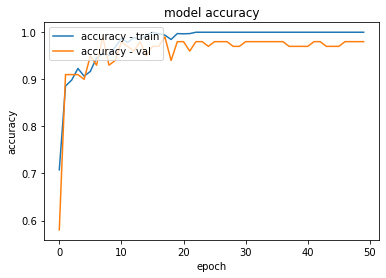

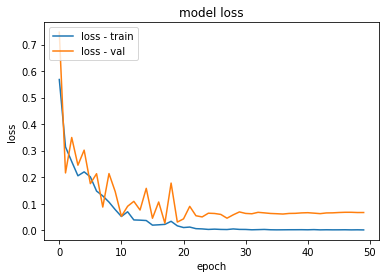

In [159]:
# Cell 26: Obtain statistics from the model
NN_Model_Summarizer(history)

In [160]:
# Cell 26: Load dataframe with test spectrograms. Once again a data generator is used.

test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(
    dataframe=testdataflow_full,
    directory=TEST_SPECT_PATH,    
    x_col="ID",
    y_col="Class", #<== use None if you want to omit / or don't have the test labels
    batch_size= 50,  
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=(64,64))
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
print("STEP_SIZE_TEST ",STEP_SIZE_TEST, "  test_generator.n ",test_generator.n," test_generator.batch_size ",test_generator.batch_size)

Found 400 validated image filenames.
STEP_SIZE_TEST  8   test_generator.n  400  test_generator.batch_size  50


In [ ]:
# Cell 27: Reload model with best weights saved.
###########################################################################################################
####################### RUN THIS CELL ONLY IF YOU WISH TO TEST WITHOUT NEW TRAINING #######################
###########################################################################################################
model = tf.keras.models.load_model(NEWWEIGHTSPATH)

In [ ]:
# Cell 28: Redefinition of class dictionary to be used for this task.
###########################################################################################################
####################### RUN THIS CELL ONLY IF YOU WISH TO TEST WITHOUT NEW TRAINING #######################
###########################################################################################################
audiodata_classes = {0:0, 1:1} 
backwards_classes = {v: k for k, v in audiodata_classes.items()}
print(audiodata_classes)
print(backwards_classes)
class_labels = audiodata_classes.keys()
print(class_labels)

In [161]:
# Cell 29: Classify test set
test_generator.reset()
pred=model.predict_generator(test_generator,
                             steps=STEP_SIZE_TEST,
                             verbose=1)
predicted_class_indices=np.argmax(pred,axis=1)

TrueTestLabelsList = testdataflow_full[('Class')]
TrueTestLabels = [int(i) for i in TrueTestLabelsList] #converts all labels for posterior metrics use

#Fetch labels from train gen for testing
PredictedTestLabelsList = [audiodata_classes[k] for k in predicted_class_indices]
PredictedTestLabels = [int(i) for i in PredictedTestLabelsList]  #converts all labels for posterior metrics use



print("-----------------------------------------------------------------------------------")
print("-----------------------------------------------------------------------------------")
print("True Test Labels") 
print(TrueTestLabels[0:100])
print(TrueTestLabels[100:200])
print(TrueTestLabels[200:300])
print(TrueTestLabels[300:400])
print("-----------------------------------------------------------------------------------")
print("-----------------------------------------------------------------------------------")
print("Predicted Test Labels")
print(PredictedTestLabels[0:100])
print(PredictedTestLabels[100:200])
print(PredictedTestLabels[200:300])
print(PredictedTestLabels[300:400])
print("-----------------------------------------------------------------------------------")
print("-----------------------------------------------------------------------------------")



8/8 [==============================] - 3s 377ms/step
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
True Test Labels
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [162]:
# Cell 30: Generate final model metrics

AccScore  = accuracy_score(TrueTestLabels, PredictedTestLabels)
PrecScore = precision_score(TrueTestLabels, PredictedTestLabels, average=None)
ReclScore = recall_score(TrueTestLabels, PredictedTestLabels, average=None)
F1Score   = f1_score(TrueTestLabels, PredictedTestLabels, average=None)

print('\n'+'Confusion Matrix')
print('\n'+'[[TN FP]')
print('\n'+' [FN TP]]'+'\n')
print(confusion_matrix(TrueTestLabels, PredictedTestLabels))

print(AccScore)


Confusion Matrix

[[TN FP]

 [FN TP]]

[[197   3]
 [ 28 172]]
0.9225
